In [80]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xg
import numpy as np

from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.preprocessing import Imputer, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier

%matplotlib inline

In [2]:
titanic_train = pd.read_csv("../data/train.csv")
titanic_test = pd.read_csv("../data/test.csv")

In [3]:
titanic_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
titanic_test.sample(20)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
335,1227,1,"Maguire, Mr. John Edward",male,30.00,0,0,110469,26.0000,C106,S
235,1127,3,"Vendel, Mr. Olof Edvin",male,20.00,0,0,350416,7.8542,NaN,S
254,1146,3,"Wenzel, Mr. Linhart",male,32.50,0,0,345775,9.5000,NaN,S
272,1164,1,"Clark, Mrs. Walter Miller (Virginia McDowell)",female,26.00,1,0,13508,136.7792,C89,C
121,1013,3,"Kiernan, Mr. John",male,NaN,1,0,367227,7.7500,NaN,Q
155,1047,3,"Duquemin, Mr. Joseph",male,24.00,0,0,S.O./P.P. 752,7.5500,NaN,S
57,949,3,"Abelseth, Mr. Olaus Jorgensen",male,25.00,0,0,348122,7.6500,F G63,S
281,1173,3,"Peacock, Master. Alfred Edward",male,0.75,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S
35,927,3,"Katavelas, Mr. Vassilios (Catavelas Vassilios"")""",male,18.50,0,0,2682,7.2292,NaN,C
249,1141,3,"Khalil, Mrs. Betros (Zahie Maria"" Elias)""",female,NaN,1,0,2660,14.4542,NaN,C


I'm taking out the names for now

In [5]:
X_train = titanic_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin', 'Name']]
y_train = titanic_train['Survived']

X_test = titanic_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin', 'Name']]

In [6]:
# Cabin is a bit unwieldy. I'm going to just take the general area.
# "U" means unknown

X_train.loc[:, 'Cabin'].fillna('U', inplace = True)
X_train.loc[:, 'Cabin'] = X_train.loc[:, 'Cabin'].apply(lambda n: n[0])

X_test.loc[:, 'Cabin'].fillna('U', inplace = True)
X_test.loc[:, 'Cabin'] = X_test.loc[:, 'Cabin'].apply(lambda n: n[0])

/home/deadhand/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/deadhand/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
# There are also missing values in Embarked

X_train.loc[:, 'Embarked'].fillna('U', inplace = True)
X_test.loc[:, 'Embarked'].fillna('U', inplace = True)

/home/deadhand/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [8]:
# Let's also try to do something with names
# X_train.loc[:, 'LastName'] = X_train.loc[:, "Name"].apply(lambda x: x.split(' ')[0])
X_train.loc[:, 'Honorific'] = X_train.loc[:, "Name"].apply(lambda x: x.split(', ')[1].split(' ')[0])
X_train.drop('Name', axis = 1, inplace = True)

# X_test.loc[:, 'LastName'] = X_test.loc[:, "Name"].apply(lambda x: x.split(' ')[0])
X_test.loc[:, 'Honorific'] = X_test.loc[:, "Name"].apply(lambda x: x.split(', ')[1].split(' ')[0])
X_test.drop('Name', axis = 1, inplace = True)

/home/deadhand/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/deadhand/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/deadhand/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.o

In [9]:
# I tried to bin Age but wasn't able to find anything that improved cross-validation

X_train_Age = pd.qcut(X_train.Age, 5)

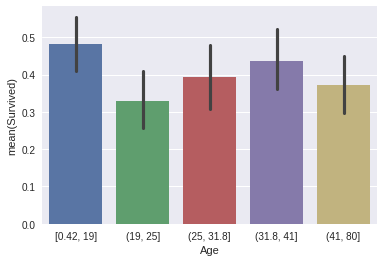

In [10]:
df_train = pd.DataFrame({'Age': X_train_Age,
                         'Survived': y_train})

sns.barplot(x="Age", y="Survived", data=df_train)

In [11]:
categories_to_encode = ['Embarked', 'Cabin', 'Sex', 'Honorific']

# Need to temporarily merge in case of new labels in test
X_combined = pd.concat([X_train[categories_to_encode], X_test[categories_to_encode]])

for category in categories_to_encode:
    labels = LabelEncoder()
    labels.fit(X_combined[category])    
    X_train[category] = labels.transform(X_train[category])
    X_test[category] = labels.transform(X_test[category])

/home/deadhand/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/deadhand/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
mean_imputer = Imputer(strategy='mean')
X_train[['Age', 'Fare']] = mean_imputer.fit_transform(X_train[['Age', 'Fare']])
X_test[['Age', 'Fare']] = mean_imputer.transform(X_test[['Age', 'Fare']])
# Would use MICE, but I'm getting compiler errors

/home/deadhand/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/deadhand/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/deadhand/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [13]:
# This makes a big difference for SVC and KNN but not the others
# RF and XGB are feature invariant and maybe RC is regularizing 
# the scaled features?

scaler = StandardScaler()
X_train[['Age', 'Fare']] = scaler.fit_transform(X_train[['Age', 'Fare']])
X_test[['Age', 'Fare']] = scaler.transform(X_test[['Age', 'Fare']])

/home/deadhand/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/deadhand/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/deadhand/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

In [16]:
X_train.sample(20)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin,Honorific
589,3,1,0.000000,0,0,-0.486337,2,8,12
681,1,1,-0.207709,0,0,0.896497,0,3,12
547,2,1,0.000000,0,0,-0.369305,0,8,12
865,2,0,0.946606,0,0,-0.386671,2,8,13
645,1,1,1.408333,1,0,0.896497,0,3,12
321,3,1,-0.207709,0,0,-0.489442,2,8,12
398,2,1,-0.515526,0,0,-0.437007,2,8,4
743,3,1,-0.438572,1,0,-0.324253,2,8,12
255,3,0,-0.053800,0,2,-0.341452,0,8,13
657,3,0,0.177063,1,1,-0.336334,1,8,13


In [43]:
X_combined = pd.concat([X_train, X_test])
dummy_combined = pd.get_dummies(X_combined, 
               columns = ['Pclass', 'Sex', 'Embarked', 'Cabin', 'Honorific'], 
               drop_first=True)

X_train = dummy_combined.iloc[:X_train.shape[0], :]
X_test = dummy_combined.iloc[X_train.shape[0]:, :]

# Let's get a baseline with a few common models

In [67]:
accuracy_scorer = make_scorer(accuracy_score)
cross_val_scores = []

In [68]:
ridge = RidgeClassifier()
cvs = cross_val_score(ridge, X_train, y_train, scoring=accuracy_scorer, cv = 10).mean()
print(cvs)
cross_val_scores.append(cvs)

0.82834865509


In [69]:
xgb = xg.XGBClassifier()
cvs = cross_val_score(xgb, X_train, y_train, scoring=accuracy_scorer, cv = 10).mean()
print(cvs)
cross_val_scores.append(cvs)

0.836238508682


In [70]:
random_forest = RandomForestClassifier()
cvs = cross_val_score(random_forest, X_train, y_train, scoring=accuracy_scorer, cv = 10).mean()
print(cvs)
cross_val_scores.append(cvs)

0.809309669731


In [71]:
svc = SVC()
cvs = cross_val_score(svc, X_train, y_train, scoring=accuracy_scorer, cv = 10).mean()
print(cvs)
cross_val_scores.append(cvs)

0.833891442515


In [72]:
knn = KNeighborsClassifier()
cvs = cross_val_score(knn, X_train, y_train, scoring=accuracy_scorer, cv = 10).mean()
print(cvs)
cross_val_scores.append(cvs)

0.826062875951


In [73]:
naive_bayes = BernoulliNB()
cvs = cross_val_score(naive_bayes, X_train, y_train, scoring=accuracy_scorer, cv = 10).mean()
print(cvs)
cross_val_scores.append(cvs)

0.783465554421


In [74]:
mlp = MLPClassifier()
cvs = cross_val_score(mlp, X_train, y_train, scoring=accuracy_scorer, cv = 10).mean()
print(cvs)
cross_val_scores.append(cvs)

0.814902962206


## Ensemble Everything in a Voting Classifier

In [86]:
normed_cross_val_scores = cross_val_scores / sum(cross_val_scores)
voter = VotingClassifier([('ridge', ridge), 
                          ('xgb', xgb),
                          ('svc', svc),
                          ('knn', knn),
                          ('naive_bayes', naive_bayes),
                          ('mlp', mlp),
                          ('random_forest', random_forest)],
                         weights = list(normed_cross_val_scores))
cross_val_score(voter, X_train, y_train, scoring=accuracy_scorer, cv = 10).mean()

0.83729996595165146

In [87]:
voter.fit(X_train, y_train)


/home/deadhand/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0,

In [93]:
submission = pd.DataFrame({'PassengerId': titanic_test['PassengerId'],
                          'Survived': voter.predict(X_test)})
submission.to_csv('../results/voting_submission.csv', index = False)

### Possible TODOs

- Get MICE working for imputation
- Hyperparameter optimization
- Make a submission